In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
from packaging import version

In [2]:
import tensorflow.keras as keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras import losses
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.models import load_model

Using TensorFlow backend.


In [3]:
import tensorflow as tf

print(tf.__version__)

1.14.0


In [4]:
%load_ext tensorboard

In [5]:
from sklearn.metrics import confusion_matrix
import itertools

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

samples= 5
tipo = 3    # np.random.randint(4)
index_image = np.random.randint(100000)  


# ========== EXTRACCIÓN DE DATOS ==============
archivo = open('./dataset/HiTS2013_100k_samples(4_channels)_images_labels.pkl',"rb")
example_dict= pickle.load(archivo)
print(example_dict['labels'].shape)
print(example_dict['images'].shape)

L=example_dict['labels'].shape[0] #numero total de imagenes

(100000,)
(100000, 21, 21, 4)


In [7]:
x_all=example_dict['images']
x_all_padded=np.pad(x_all, ((0,0),(3,3), (3,3), (0, 0)), 'constant')
print(x_all_padded.shape)

(100000, 27, 27, 4)


In [8]:
percentage_train=0.75

percentage= int(percentage_train*L)
#xx = example_dict['images'][:, :, :, tipo]
xx = x_all_padded[:, :, :, tipo]
yy= example_dict['labels']
print('Dimension of images to train:',xx[:percentage].shape)
print('Dimension of images to test:',xx[percentage:].shape)
print('Number of images to train: ', yy[:percentage].shape[0])
print('Number of images to test: ',yy[percentage:].shape[0])

#database to train
x_train=xx[:percentage]
y_train=yy[:percentage]

#database to test
x_test=xx[percentage:]
y_test=yy[percentage:]

#input shape para las redes convolucionales
input_shape1=x_test.shape[1]
input_shape2=x_test.shape[2]
print('\n\ninput_shape: ' , input_shape1, 'x', input_shape2)

input_shape = (input_shape1, input_shape2, 1)

Dimension of images to train: (75000, 27, 27)
Dimension of images to test: (25000, 27, 27)
Number of images to train:  75000
Number of images to test:  25000


input_shape:  27 x 27


In [9]:
x_train_all=x_all[:percentage]
x_test_all=x_all[percentage:]
print(x_train_all.shape)
print(x_test_all.shape)

(75000, 21, 21, 4)
(25000, 21, 21, 4)


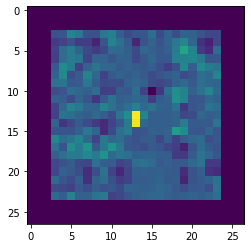

In [10]:
%matplotlib inline
plt.imshow(x_train[0])#,cmap=plt.cm.binary)
plt.show()

In [11]:
print('falso: ', y_train[0])

falso:  0


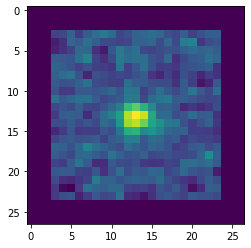

In [12]:
%matplotlib inline
plt.imshow(x_train[4])#,cmap=plt.cm.binary)
plt.show()

In [13]:
print('positivo: ', y_train[4])

positivo:  1


In [14]:
# Reshape the images.
r_x_train= np.expand_dims(x_train, axis=3)
r_x_test = np.expand_dims(x_test, axis=3)
print(r_x_train.shape)
print(r_x_test.shape)

(75000, 27, 27, 1)
(25000, 27, 27, 1)


In [15]:
############ modelo Conv Keras #################


def CNN_model():


#     model = Sequential([
#       Conv2D(num_filters, filter_size, padding='same', input_shape=input_shape),
#       MaxPooling2D(pool_size=pool_size),
#     ])

#     model.add(Flatten())
#     model.add(Dense(10))
#     model.add(Activation('relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(2))
#     model.add(Activation('softmax'))

    model = Sequential()
    #conv
    model.add(Conv2D(32, kernel_size=(4, 4), padding='same', strides=(1, 1),
                     input_shape=input_shape))
    #conv
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', strides=(1, 1)))
    #max-pool
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    #conv
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1)))
    #conv
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1)))
    #conv
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1)))              
    #max-pool
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Dense(64))
    model.add(Dropout(0.5))

    model.add(Dense(2))
    model.add(Activation('softmax'))

    adam=optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False) #Adam optimizer

    loss_cce = losses.sparse_categorical_crossentropy   #sparse categorical crossentropy

    model.compile(optimizer=adam,
                  loss=loss_cce,
                  metrics=['accuracy'])
    return model

In [16]:
model=CNN_model()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 27, 27, 32)        544       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [18]:
#entrenar
epocas=30
batch=10

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit(r_x_train, y_train, validation_split=0.25, batch_size=batch, epochs=epocas,callbacks=[es]) #[tensorboard_callback])




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 56250 samples, validate on 18750 samples
Epoch 1/30
56250/56250 [==============================] - 126s 2ms/step - loss: 0.1818 - acc: 0.9331 - val_loss: 0.1452 - val_acc: 0.9488
Epoch 2/30
56250/56250 [==============================] - 124s 2ms/step - loss: 0.1514 - acc: 0.9491 - val_loss: 0.1311 - val_acc: 0.9529
Epoch 3/30
56250/56250 [==============================] - 123s 2ms/step - loss: 0.1430 - acc: 0.9520 - val_loss: 0.1502 - val_acc: 0.9508
Epoch 00003: early stopping


In [19]:
print('\n\nTesting Accuracy y Loss...\n\n')

val_loss, val_acc = model.evaluate(r_x_test, y_test)
print('\n\nLoss:', val_loss*100,'%\n\n')
print('Accuracy:', val_acc*100,'%\n\n')



Testing Accuracy y Loss...


25000/25000 [==============================] - 12s 463us/step


Loss: 15.536523574903608 %


Accuracy: 94.93599999999999 %




In [20]:
model.save('super_nova_class.model')

In [21]:
new_model = load_model('super_nova_class.model')

In [22]:
predictions_t = new_model.predict(r_x_test, batch_size=batch)
print(predictions_t)

[[1.5925469e-02 9.8407459e-01]
 [2.8153792e-05 9.9997187e-01]
 [4.2580771e-03 9.9574190e-01]
 ...
 [9.5774412e-01 4.2255815e-02]
 [9.9920279e-01 7.9719204e-04]
 [9.9808276e-01 1.9173103e-03]]


In [23]:
for i in range(20):
    print('prediction: ',np.argmax(predictions_t[i]), ' -----  true class: ', y_test[i])
    

prediction:  1  -----  true class:  1
prediction:  1  -----  true class:  1
prediction:  1  -----  true class:  1
prediction:  0  -----  true class:  0
prediction:  1  -----  true class:  0
prediction:  1  -----  true class:  1
prediction:  1  -----  true class:  1
prediction:  1  -----  true class:  0
prediction:  0  -----  true class:  0
prediction:  0  -----  true class:  0
prediction:  1  -----  true class:  1
prediction:  1  -----  true class:  1
prediction:  0  -----  true class:  0
prediction:  1  -----  true class:  1
prediction:  0  -----  true class:  0
prediction:  1  -----  true class:  1
prediction:  0  -----  true class:  0
prediction:  1  -----  true class:  1
prediction:  0  -----  true class:  0
prediction:  0  -----  true class:  0


In [24]:
Samples=30

# Predict on the first 5 test images.
predictions = model.predict(r_x_test[:Samples], batch_size=batch)


#r=range(Samples)
#l = [*r]
#print (l[:Samples])

# Print our model's predictions.
print('predict ', np.argmax(predictions, axis=1)) 

# Check our predictions against the ground truths.
print('class:  ', y_test[:Samples])



predict  [1 1 1 0 1 1 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0]
class:   [1 1 1 0 0 1 1 0 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0]


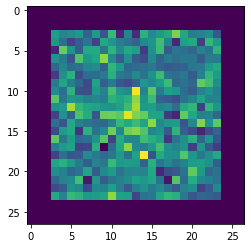

 imagem: 3 ----- tipo: 3 ----- class: 0 ----- prediction: 0 


In [25]:
%matplotlib inline
index_img=3
plt.figure("imagem: {} , tipo: {} , class: {}".format(index_img, tipo, y_test[index_img]))
plt.imshow(x_test[0])#,cmap=plt.cm.binary)


plt.show()
print(" imagem: {} ----- tipo: {} ----- class: {} ----- prediction: {} ".format(index_img, tipo, y_test[index_img], np.argmax(predictions[index_img])))


In [26]:
imagene_index=3


test_predict = model.predict(r_x_test[imagene_index:imagene_index+1], batch_size=batch)
print('prediction test: ', test_predict)
print('prediction class test: ', np.argmax(test_predict), 'percentage: ', "%.2f" % (test_predict[0][np.argmax(test_predict)]*100), '%')

if(np.argmax(test_predict)==y_test[imagene_index]):
    print('acertou!')
else:
    print('errou!')


prediction test:  [[0.5800732  0.41992673]]
prediction class test:  0 percentage:  58.01 %
acertou!


In [27]:
r_x_train[0].shape

(27, 27, 1)

In [28]:
x_train[0].shape

(27, 27)

In [29]:
imagene_index_t=0
typ_im=1


xx_test = example_dict['images'][:, :, :, typ_im]

r_xx_test= np.expand_dims(xx_test, axis=3)

test_predict_t = model.predict(r_xx_test[imagene_index_t:imagene_index_t+1])
print('prediction test: ', test_predict_t)
print('\n\n\nprediction class test: ', np.argmax(test_predict_t), 'percentage: ', "%.2f" % (test_predict_t[0][np.argmax(test_predict_t)]*100), '%')
print()
if(np.argmax(test_predict)==y_test[imagene_index_t]):
    print('acertou!')
else:
    print('errou!')


ValueError: Error when checking : expected conv2d_1_input to have shape (27, 27, 1) but got array with shape (21, 21, 1)

In [30]:
print('list: ',history.history.keys())
print('loss: ',history.history['val_loss'])

list:  dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
loss:  [0.14517915504003565, 0.13107756477698276, 0.15015153801203074]


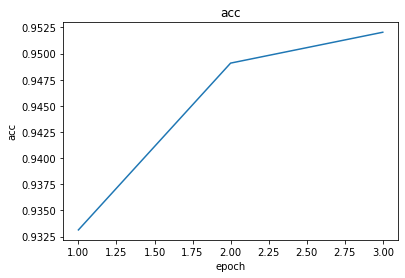

In [31]:
parametro='acc'

x_axis = np.arange(1,len(history.history[parametro])+1,1)
y_axis = history.history[parametro]

plt.plot(x_axis,y_axis)
plt.xlabel('epoch')
plt.ylabel(parametro)
plt.title(parametro)
plt.show()

In [32]:
unos_train=0
ceros_train=0
unos_test=0
ceros_test=0

for val_train in y_train:

    if val_train==1:
        unos_train+=1
    else:
        ceros_train+=1


for val_test in y_test:

    if val_test==1:
        unos_test+=1
    else:
        ceros_test+=1    
        
print('unos_train: ', unos_train)
print('ceros_train: ', ceros_train)
print('percentage: %.2f' % (100*(unos_train/(unos_train+ceros_train))), '%')
print('\n\n\n')
print('unos_test: ', unos_test)
print('ceros_test: ', ceros_test)
print('percentage: %.2f' % (100*(unos_test/(unos_test+ceros_test))),'%')

unos_train:  37509
ceros_train:  37491
percentage: 50.01 %




unos_test:  12491
ceros_test:  12509
percentage: 49.96 %


In [33]:
print('y_test: ', y_test.shape)
print('np.argmax(predictions, axis=1)', np.argmax(predictions_t, axis=1).shape)
test_labels=y_test
rounded_predictions= model.predict_classes(r_x_test, batch_size=batch)


cm= confusion_matrix(test_labels, rounded_predictions)

cm_2= np.zeros((2,2), dtype=int)
print(cm_2)
cm_2[0,0]=cm[1,1]
cm_2[1,1]=cm[0,0]
cm_2[1,0]=cm[0,1]
cm_2[0,1]=cm[1,0]
print(cm_2)

cm=cm_2

TP=cm_2[0,0]
TN=cm_2[1,1]
FP=cm_2[1,0]
FN=cm_2[0,1]

#print('[%d, %d]' % (TP, FN))
#print('[%d, %d]' % (FP, TN))

y_test:  (25000,)
np.argmax(predictions, axis=1) (25000,)
[[0 0]
 [0 0]]
[[12385   106]
 [ 1160 11349]]


In [34]:
def plot_confusion_matrix(cm, classes, 
                          normalize=False, 
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matix.
    Normalize can be applied by setting 'normalize=True'
    '''
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm= cm.astype('float') / cm.sum(axis-1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, without normalization')
        
        
    print(cm)

    thresh = cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j], 
                 horizontalalignment = 'center', 
                 color = 'white' if cm[i,j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[12385   106]
 [ 1160 11349]]


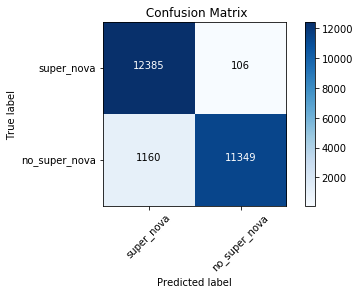

In [35]:
cm_plot_labels = ['super_nova','no_super_nova']
plot_confusion_matrix(cm,cm_plot_labels, title = ' Confusion Matrix')



In [36]:
print('       ESTADISTICAS      \n')
print('Valor máximo :', x_train.max())
print('Valor mínimo :', x_train.min())
print('Valor promedio :', x_train.mean())
print('Valor varianza :', x_train.var())
print('Valor desviación standar :', x_train.std())

       ESTADISTICAS      

Valor máximo : 1.0
Valor mínimo : 0.0
Valor promedio : 0.26125285
Valor varianza : 0.06920705
Valor desviación standar : 0.26307234


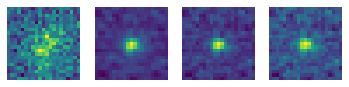

In [37]:
indeximage=4

for i in range(4):
    plt.subplot(1, 4, i+1)
    ximg=example_dict['images'][:,:,:,i]
    plt.imshow(ximg[indeximage])
    plt.axis('off')

plt.show()


In [ ]:
%tensorboard --logdir logs/scalars

In [ ]:
predictions_t = new_model.predict(r_x_test[2:3])
print(r_x_test[2:3].shape)
print(predictions_t)

In [ ]:
predictions_t = new_model.predict(r_x_test)
print(r_x_test.shape)
print(predictions_t[2])

In [ ]:
predictions_t = new_model.predict(np.expand_dims(r_x_test[2], axis=0))
print(np.expand_dims(r_x_train[2], axis=0).shape)
print(np.argmax(predictions_t))